1-Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


2-Reading Excel file

In [2]:
df = pd.read_csv(r"C:\Users\kumai\Desktop\auto-mpg.csv")
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


3-Clean Data

In [3]:


# Replace '?' with NaN
df = df.replace("?", np.nan)

# Convert numeric columns to correct type
df["horsepower"] = pd.to_numeric(df["horsepower"], errors='coerce')

# Drop missing values
df = df.dropna()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


4-EDA

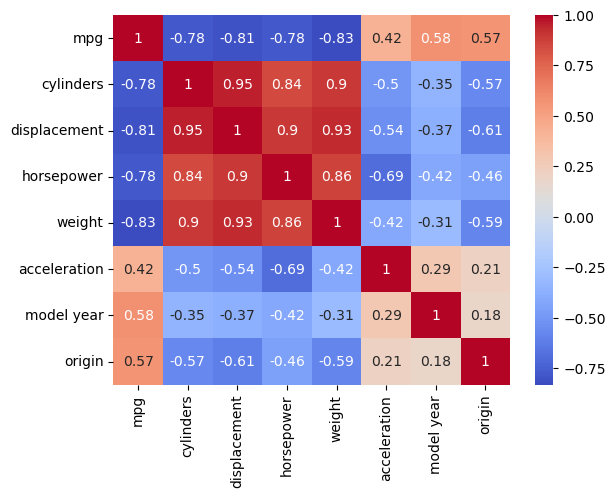

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

if 'car name' in df.columns:
    df = df.drop(columns=['car name'])

numeric_cols = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year']



sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


5 — Feature Selection

In [5]:
X = df[['cylinders','displacement','horsepower','weight']]
y = df['mpg']


6— Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


7 — Feature Scaling (for Linear Regression only)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


8 — Model 1: Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

print("Linear Regression Results:")
print("MAE:", mean_absolute_error(y_test, lr_pred))
print("MSE:", mean_squared_error(y_test, lr_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("R²:", r2_score(y_test, lr_pred))


Linear Regression Results:
MAE: 3.488190580941961
MSE: 17.89193621074136
RMSE: 4.229886075385643
R²: 0.6494566661462675


9 — Model 2: Random Forest Regressor

In [9]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest Results:")
print("MAE:", mean_absolute_error(y_test, rf_pred))
print("MSE:", mean_squared_error(y_test, rf_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("R²:", r2_score(y_test, rf_pred))


Random Forest Results:
MAE: 2.903835443037973
MSE: 16.667437056258795
RMSE: 4.082577256618519
R²: 0.673447362896891


10 — Compare Model Performance

In [10]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R2 Score": [r2_score(y_test, lr_pred), r2_score(y_test, rf_pred)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, lr_pred)),
             np.sqrt(mean_squared_error(y_test, rf_pred))]
})

results


,Model,R2 Score,RMSE
0,Linear Regression,0.649457,4.229886
1,Random Forest,0.673447,4.082577


11 — Feature Importance (Random Forest)

In [11]:
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
1,displacement,0.462874
2,horsepower,0.224403
3,weight,0.176887
0,cylinders,0.135836


12 — Predict on New Car Input

In [12]:
new_car = pd.DataFrame({
    'cylinders':[4],
    'displacement':[140],
    'horsepower':[90],
    'weight':[2500]
})

new_car_scaled = scaler.transform(new_car)
print("Linear Regression MPG Prediction:", lr.predict(new_car_scaled))
print("Random Forest MPG Prediction:", rf.predict(new_car))


Linear Regression MPG Prediction: [27.35503595]
Random Forest MPG Prediction: [26.59533333]


In [13]:
import gradio as gr
import pandas as pd
import numpy as np

def predict_mpg_linear(displacement, horsepower, weight, cylinders):
    input_df = pd.DataFrame(
        [[cylinders, displacement, horsepower, weight]],
        columns=['cylinders', 'displacement', 'horsepower', 'weight']
    )
    
    input_scaled = scaler.transform(input_df)
    prediction = lr.predict(input_scaled)
    return round(float(prediction[0]), 2)


app = gr.Interface(
    fn=predict_mpg_linear,
    inputs=[
        gr.Number(label="Displacement (70–460 cubic inches)"),
        gr.Number(label="Horsepower (45–230)"),
        gr.Number(label="Weight (1600–5200 lbs)"),
        gr.Number(label="Cylinders (3–8)")
    ],
    outputs=gr.Number(label="Predicted MPG"),
    title="Fuel Efficiency Prediction (Linear Regression)",
    description="Predict MPG using core vehicle attributes: displacement, horsepower, weight, and cylinders."
)

app.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [14]:
import joblib
joblib.dump(rf, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [15]:
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI(title="Fuel Efficiency Prediction API")

model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")

@app.post("/predict")
def predict(displacement: float, horsepower: float, weight: float, cylinders: float):
    input_df = pd.DataFrame(
        [[cylinders, displacement, horsepower, weight]],
        columns=['cylinders', 'displacement', 'horsepower', 'weight']
    )
    
    input_scaled = scaler.transform(input_df)
    mpg = model.predict(input_scaled)[0]
    
    return {"predicted_mpg": round(float(mpg), 2)}


In [16]:
uvicorn fastapi_app:app --reload


SyntaxError: invalid syntax (2485913125.py, line 1)

In [17]:
fastapi_app.py


NameError: name 'fastapi_app' is not defined